In [1]:
import numpy as np
import sklearn.metrics
from confidence_intervals import evaluate_with_conf_int
from confidence_intervals.utils import create_data

In [2]:
# Create a toy dataset. Here the samples are simply the decisions made by the system.
N0 = 200
N1 = 200
NC = 20
decisions, labels, conditions = create_data(N0, N1, NC, scale=1.0)

# Percentage for the confidence interval
alpha = 5 

# Number of bootstrap samples to use (the run time will be proportional to this number). We set it to
# 50/alpha*100 to get enough samples in the tails.
num_bootstraps = int(50/alpha*100)


Below we show the simplest way to obtain both the metric on the complete dataset and the confidence interval, in a single line of code.


In [3]:
metric =  sklearn.metrics.accuracy_score
evaluate_with_conf_int(decisions, metric, labels=labels, conditions=conditions, 
                       num_bootstraps=num_bootstraps, alpha=alpha)


(0.855, (0.7938131968651883, 0.9126023142471228))

Alternatively, one can compute the accuracy as the average of the 0-1 loss. In this case, we need to set the labels argument to None, define the samples argument (the first one) as the 0-1 loss, and the metric as the mean. 

This same approach can be used for ASR or diarization where the metric is an average of per-sample losses that are not quick to compute. In that case, the samples array should contain the per-sample losses, replacing the 0-1 loss used below. 

In [4]:
losses = decisions == labels
evaluate_with_conf_int(losses, np.average, labels=None, conditions=conditions, 
                       num_bootstraps=num_bootstraps, alpha=alpha)

(0.855, (0.7938131968651883, 0.9126023142471228))

In some cases, the metric is a weighted average of per-sample losses. In that case, the labels array can be used to provide the weight to the metric, which can be defined as below.

In [5]:
losses = decisions == labels

# Setting all the weights to 1, the metric is the accuracy, as above. 
weights = np.ones_like(losses)

def metric(weights, losses):
    return np.average(losses, weights=weights)

evaluate_with_conf_int(losses, metric, labels=weights, conditions=conditions, 
                       num_bootstraps=num_bootstraps, alpha=alpha)

(0.855, (0.7938131968651883, 0.9126023142471228))

The block below shows the few lines of code needed to run bootstrapping, unwrapping evaluate_with_conf_int. This shows how straightforward the approach is. The only somewhat complex step is inside the get_bootstrap_indices method for the case that involves conditions. 

You can use this as pseudo-code if, for example, you need to recode bootstrapping in some other language or compute a more involved metric that does not take only samples and labels as input.

In [6]:
from confidence_intervals import get_bootstrap_indices, get_conf_int

metric =  sklearn.metrics.accuracy_score
metric_values = []
num_samples = len(decisions)
for nb in np.arange(num_bootstraps):
    indices = get_bootstrap_indices(num_samples, conditions=conditions, random_state=nb)
    metric_values.append(metric(labels[indices], decisions[indices]))

print(metric(labels, decisions), get_conf_int(metric_values, alpha))




0.855 (0.7938131968651883, 0.9126023142471228)


Below is an example on how to create a bar plot for two systems, with and without using conditions when determining the bootstrap sets.

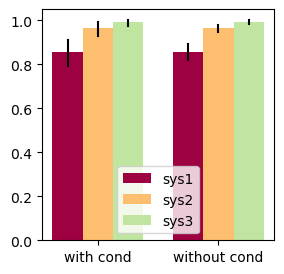

In [7]:
from confidence_intervals.utils import barplot_with_ci
metric =  sklearn.metrics.accuracy_score

# The create_data method generates the same labels and conditions for all three cases below. 
# Only the decisions change, simulating three different systems.
decisions = {}
decisions['sys1'], labels, conditions = create_data(N0, N1, NC, scale=1.0)
decisions['sys2'], labels, conditions = create_data(N0, N1, NC, scale=0.5)
decisions['sys3'], labels, conditions = create_data(N0, N1, NC, scale=0.3)

data = {}
for sys, dec in decisions.items():
   val_with_cond = evaluate_with_conf_int(dec, metric, labels, conditions, num_bootstraps=num_bootstraps, alpha=alpha)
   val_no_cond   = evaluate_with_conf_int(dec, metric, labels, None,       num_bootstraps=num_bootstraps, alpha=alpha)
   data[sys] = {'with cond': val_with_cond, 'without cond': val_no_cond}

barplot_with_ci(data, figsize=(3,3))


Finally, we show how to create a confidence interval for comparing the performance between two of the systems above. 

Note that, in this example, the confidence intervals for systems 2 and 3 above overlap almost completely. Yet, the confidence interval for the difference in metric does not contain 0, meaning that we can reject the hypothesis that the two systems perform equally well on this dataset. That is, if we were to draw new test datasets, system 3 would still perform better than system 2 for most of those datasets, though only marginally so.

In [8]:
from confidence_intervals import get_bootstrap_indices, get_conf_int

base_metric = sklearn.metrics.accuracy_score

def metric(labels, dec1, dec2):
    return base_metric(labels, dec2) - base_metric(labels, dec1)

evaluate_with_conf_int(decisions['sys2'], metric, labels, conditions, samples2=decisions['sys3'],
                       num_bootstraps=num_bootstraps, alpha=alpha)


(0.02750000000000008, (0.002737195937398332, 0.062345636819321044))